# Machine Learning - Practical 3 - Multiclass Logistic Regression, MLP and CNNs


Names: {YOUR NAMES}  
Summer Term 2023   
Due Date: Tuesday, May 30, 2pm

**Please note that this practical requires training a lot of models, which may be time consuming (~2h)**

In this practical we will implement multiclass classification with classic Logistic Regression, Multilayer Preceptron, and the convolutional neural network LeNet5 on image data. We will compare the performance of these models. You will work on the following:

 1. Imports and Hardware check
 2. Loading data and related transformations 
 3. Defining training helper functions and metrics 
 4. Logistic Regression 
 5. MLP
 6. CNN
 7. Comparison of results across models

We'll be storing all the losses and accuracies while training, and plotting everything in the end. Use `tqdm` to keep track of your training and validation losses and accuracies since we're only plotting them in the end.

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

torch.manual_seed(42) # Set manual seed

In [ ]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

## Define data transformations

We will work with the CIFAR-10 dataset, an established computer vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. The goal of this dataset is to predict the image class.

Note: The constants in `transforms.Normalize()` are the means and standard deviations of the three color channels of the images in the CIFAR-10 training set. You can verify these numbers yourself by re-computing them.

In [ ]:
batch_size = 256

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

In [ ]:
# Load the data and transform the dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform= transforms.ToTensor())
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform= transforms.ToTensor())

# You can verify the mean and standard deviation used in the normalization above by calculating the mean and std of the training dataset above.  
train_tensor = torch.stack([img for img, _ in train_dataset])
print(train_tensor.shape)
 
train_mean = torch.mean(train_tensor, dim = [0, 2, 3])
train_std = torch.std(train_tensor, dim = [0, 2, 3])

print(f"mean : {train_mean}\nstd : {train_std}")

In [ ]:
# TODO: make dataloaders (from torch.utils) from datasets, define batch size and do not forget shuffling 
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle=True)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size= batch_size)

 

In [ ]:
## TODO: plot images with their labels after augmentations
def show_batch(dl, nrow=8):
    images, labels = next(iter(dl))
    images = images.numpy().transpose((0, 2, 3, 1))
    ncol = (len(images) + nrow - 1) // nrow
    fig, axes = plt.subplots(ncol, nrow, figsize=(12, 1.5 * ncol))
    for img, label, ax in zip(images, labels, axes.ravel()):
        ax.imshow(img)
        ax.set_title(label.item())
        ax.axis('off')

In [ ]:
show_batch(train_loader)

In [ ]:
num_classes = 10

## Define helper functions for training and metrics

You will need these again and again. 

In [ ]:
## TODO: write a function that calculates the accuracy

def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    return correct / total

In [ ]:
## TODO: Define a train and validation functions here
## Hint - you can use yours from Practical 2 


def train(dataloader, optimizer, model, loss_fn, device):
    """ method to train the model """
    # Set the model to training mode
    model.train()
    # Get the size of the training dataset
    size = len(dataloader.dataset)
    # Initialize a variable to keep track of the number of correct predictions
    correct = 0
    # Initialize a list to store the losses for each batch
    losses = []
    # Loop over each batch of data provided by the dataloader
    for batch, (X, y) in enumerate(dataloader):
        # Move the data to the specified device (CPU or GPU)
        X, y = X.to(device), y.to(device)
        # Make predictions using the model
        pred = model(X)
        # Calculate the loss between the predictions and true labels
        loss = loss_fn(pred, y)
        # Append the loss to the list of losses
        losses.append(loss.item())
        # Zero out any accumulated gradients
        optimizer.zero_grad()
        # Compute gradients by backpropagating the loss
        loss.backward()
        # Update the model's parameters using the optimizer
        optimizer.step()
        # Update the number of correct predictions
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculate accuracy as the ratio of correct predictions to total number of samples
    acc = accuracy(correct, size)
    # Calculate mean loss as the average of all batch losses
    mean_loss = sum(losses) / len(losses)
    return mean_loss, acc
    

def validate(dataloader, model, loss_fn, device):
    """ method to compute the metrics on the validation set """
    # Get the size of the validation dataset
    size = len(dataloader.dataset)
    # Get the number of batches in the dataloader
    num_batches = len(dataloader)
    # Set the model to evaluation mode
    model.eval()
    # Initialize variables to keep track of the total loss and number of correct predictions
    test_loss, correct = 0, 0
    # Disable gradient computation
    with torch.no_grad():
        # Loop over each batch of data provided by the dataloader
        for X, y in dataloader:
            # Move the data to the specified device (CPU or GPU)
            X, y = X.to(device), y.to(device)
            # Make predictions using the model
            pred = model(X)
            # Accumulate the loss between the predictions and true labels
            test_loss += loss_fn(pred, y).item()
            # Update the number of correct predictions
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculate mean loss as the total loss divided by the number of batches
    test_loss /= num_batches
    # Calculate accuracy as the ratio of correct predictions to total number of samples
    acc = accuracy(correct,size)
    return test_loss, acc

In [ ]:
#TODO: write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from Practical 2 
from tqdm import trange


def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    """ method to run the training procedure """
    # TODO: write a run_training function that 
  # - calls the train and validate functions for each epoch
  # - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in trange(num_epochs):
        train_loss, train_acc = train(train_dataloader, optimizer, model, loss_function, device, )
        
        val_loss, val_acc = validate(train_dataloader, model, loss_function, device)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print(f"(tain loss: {train_loss}, train acc: {train_acc}, val loss: {val_loss}, val acc: {val_acc})")
    
    return train_losses, val_losses, train_accs, val_accs

In [ ]:
# TODO: write a function to calculate and return the confusion values
def calc_confusion_values(dataloader, model, device):
    """ method to compute the confusion values on the validation set """
    # Initialize a confusion matrix of zeros with shape (num_classes, num_classes)
    confusion_matrix = torch.zeros(num_classes, num_classes)
    # Disable gradient computation
    with torch.no_grad():
        # Loop over each batch of data provided by the dataloader
        for i, (inputs, classes) in enumerate(dataloader):
            # Move the data to the specified device (CPU or GPU)
            inputs = inputs.to(device)
            classes = classes.to(device)
            # Make predictions using the model
            outputs = model(inputs)
            # Get the predicted classes by taking the index of the maximum value in the prediction tensor for each sample
            _, preds = torch.max(outputs, 1)
            # Update the confusion matrix based on the true and predicted classes
            for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    # Return the confusion matrix
    return confusion_matrix

## Logistic Regression   

In [ ]:
class LR(torch.nn.Module):
    """
    Logistic regression model inherits from the torch.nn.Module 
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LR, self).__init__()
        # TODO: define linear layer for the model
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.linear = nn.Linear(input_dim, output_dim)
        
        

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # What are the dimensions of your input layer?
        #
        # TODO: flatten the input to a suitable size for the initial layer
        x = x.view(-1,self.input_dim )
        # TODO: run the data through the layer
        outputs = self.linear(x)
        return outputs

In [ ]:
## TODO: Define network in the variable named 'linear_regression', put it to the device and train mode
linear_regression = LR(3 * 32 * 32, 10)
linear_regression = linear_regression.to(device)
linear_regression.train()

In [ ]:
## Optimiser defined. We're going to use Adam since it's always the safe bet, and also for faster convergence. 
optimizer = torch.optim.Adam(linear_regression.parameters(), lr=0.001)

### Define loss 

Since we're dealing with multi-class classification (i.e. multiple categories), softmax is the canonical choice for the final layer activation. Softmax provides us with a distribution of values in \[0, 1\] that sum up to 1 over all categories.

We then use the cross entropy to compute the loss.

Hint: Due to numerical reasons, softmax and cross entropy are combined into one operation. Read more about it in https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html.

In [ ]:
# TODO: define the loss function
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
num_epochs = 20
## TODO: run training over 20 epochs
train_losses, val_losses, train_accs, val_accs = run_training(linear_regression, optimizer, loss_function, device, num_epochs, train_loader, test_loader)

## Multilayer Perceptron

MLP is a network which consists of several linear fully-connected layers with non-linearities between them.

### Question:
Why are non-linearities between linear layers important?

### Answer:
they are important to achieve non-linear connections within the network

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        ## TODO: Make the 4 layer MLP with the following shapes :
        ## input_dim -> 1650 -> 512 -> 138 -> output_dim
        ## Use RELu as nonlinearity

        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.fc1 = nn.Linear(input_dim, 1650)
        self.fc2 = nn.Linear(1650, 512)
        self.fc3 = nn.Linear(512, 138)
        self.fc4 = nn.Linear(138,output_dim)
        
        
    def forward(self, xb):
        ## TODO: write the forward pass
        ## Do not forget to flatten the input
        xb = xb.view(-1, self.input_dim)
        xb = nn.functional.relu(self.fc1(xb))
        xb = nn.functional.relu(self.fc2(xb))
        xb = self.fc3(xb)
        xb = self.fc4(xb)
        return xb

In [ ]:
## TODO: Define network, put it to device and train mode
mlp_model = MLP(3 * 32 * 32, 10)
mlp_model = mlp_model.to(device)
mlp_model.train()


In [ ]:
## TODO: Define optimizer and loss functions
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
## TODO: Train the MLP over 20 epochs
#def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
MLP_train_losses, MLP_val_losses, MLP_train_accs, MLP_val_accs = run_training(mlp_model, optimizer, loss_function, device, num_epochs, train_loader, test_loader )

## Add L2 regularisation

In [ ]:
# TODO: Define new model, optimizer, put model to device, etc.
## 0.0005 is a good starting point for the regularization strength
mlp_model_reg = MLP(3 * 32 * 32, 10)
mlp_model_reg = mlp_model_reg.to(device)
mlp_model_reg.train()
optimizer = torch.optim.Adam(mlp_model_reg.parameters(), lr=0.001, weight_decay=0.0005)

In [ ]:
## TODO: Retrain new model with regularization over 20 epochs
MLP_reg_train_losses, MLP_reg_val_losses, MLP_reg_train_accs, MLP_reg_val_accs = run_training(mlp_model_reg, optimizer, loss_function, device, num_epochs, train_loader,test_loader)

## LeNet5

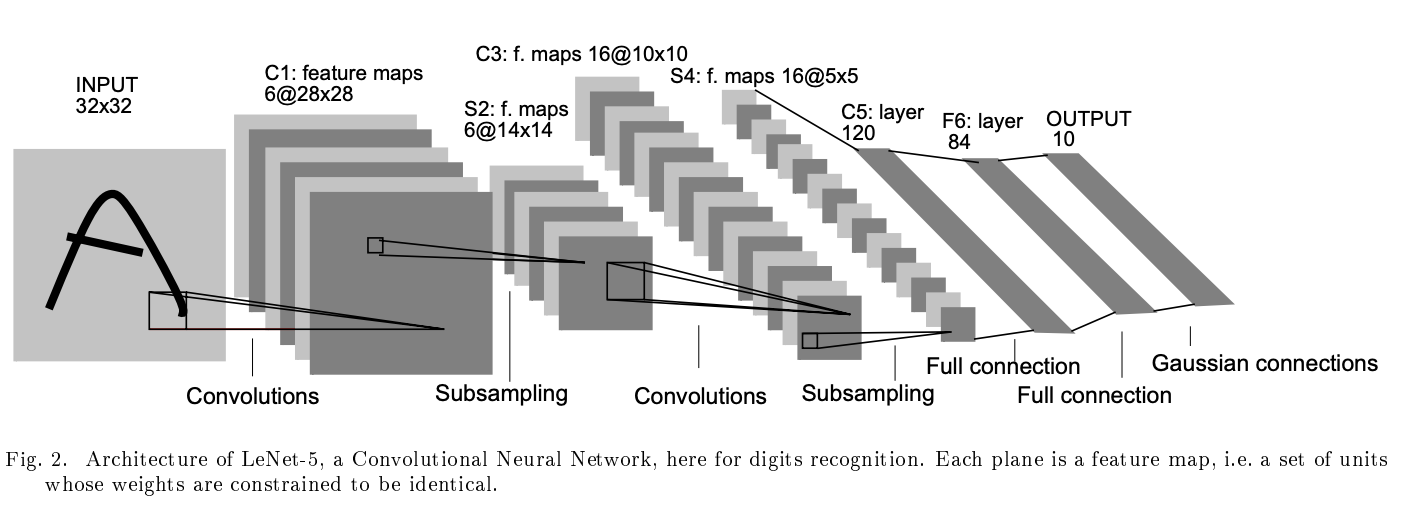

Let's implememt one of the classical convolutional network and apply it for CIFA10. Here is the link for the [original paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) of LeNet5 introduced by Yann LeCun and colleagues in 1998. The original implentation of LeNet5 has Tanh as non-linearities. In 2012, AlexNet famously set off the deep learning revolution. AlexNet is based on LeNet, with two main innovations: (1) making it deeper by adding a few extra layers and (2) replacing the tanh activation functions by ReLU to improve training. Here we'll the original LeNet5 architecture to keep the compute requirements small, but work with the more modern ReLU activation functions.

One more thing we change in the original network is the number of input channels as LeNet5 was designed for grayscale MNIST dataset, where each picture has 1 channel, while for RGB pictures we have 3 channels in the input data.


In [ ]:
class LeNet5(nn.Module):

    def __init__(self, n_classes, in_channels=1):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            ## TODO: add remaining layers, pooling and nonlinearities up to layer C5
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.ReLU()
        )
            

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            ## TODO: add ReLU nonlinearity and final classification linear layer
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes)
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
## TODO: define network, put it to the device and train mode
LeNet5_model = LeNet5(10, 3)
LeNet5_model = LeNet5_model.to(device)
LeNet5_model.train()

In [ ]:
## TODO: define loss function and optimisers
# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(LeNet5_model.parameters(), lr=0.001)

In [ ]:
## TODO: train with 20 epochs
num_epochs = 20

LeNet5_train_losses, LeNet5_val_losses, LeNet5_train_accs, LeNet5_val_accs = run_training(LeNet5_model, optimizer, loss_function, device, num_epochs, train_loader,test_loader)

## Analysis 

In [ ]:
## TODO: Plot both train and val losses for all models. 
## What do you see?

# Plot the training and validation losses for the linear regression model
plt.plot(train_losses, label='Linear Regression Train Loss')
plt.plot(val_losses, label='Linear Regression Val Loss')

# Plot the training and validation losses for the MLP model
plt.plot(MLP_train_losses, label='MLP Train Loss')
plt.plot(MLP_val_losses, label='MLP Val Loss')

#Plot the training and validation losses for the MLP model with regularisation

plt.plot(MLP_reg_train_losses, label='MLP reg Train Loss')
plt.plot(MLP_reg_val_losses, label='MLP reg Val Loss')

# Plot the training and validation losses for the LeNet5 model
plt.plot(LeNet5_train_losses, label='LeNet5 Train Loss')
plt.plot(LeNet5_val_losses, label='LeNet5 Val Loss')

# Add a legend to the plot
plt.legend()

# Add labels to the x and y axes
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Show the plot
plt.show()

In [ ]:
## TODO: Plot both train and val accuracies for all models. 
## What do you see?
# Plot the training and validation accuracies for the linear regression model
ada
plt.plot(val_accs, label='Linear Regression Val Accuracy')

# Plot the training and validation accuracies for the MLP model
plt.plot(MLP_train_accs, label='MLP Train Accuracy')
plt.plot(MLP_val_accs, label='MLP Val Accuracy')

# Plot the training and validation accuracies for the MLP model
plt.plot(MLP_reg_train_accs, label='MLP Reg Train Accuracy')
plt.plot(MLP_reg_val_accs, label='MLP Reg Val Accuracy')

# Plot the training and validation accuracies for the LeNet5 model
plt.plot(LeNet5_train_accs, label='LeNet5 Train Accuracy')
plt.plot(LeNet5_val_accs, label='LeNet5 Val Accuracy')

# Add a legend to the plot
plt.legend()

# Add labels to the x and y axes
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Show the plot
plt.show()

In [ ]:
import seaborn as sns

## TODO: Plot the confusion matrix for LeNet5
# Calculate the confusion matrix for the LeNet5 model on the validation data
confusion_matrix = calc_confusion_values(test_loader, LeNet5_model, device)

# Convert the confusion matrix to an integer data type
confusion_matrix = confusion_matrix.int()

# Create a heatmap plot of the confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')

# Add labels to the x and y axes
plt.xlabel('Predicted')
plt.ylabel('True')

# Show the plot
plt.show()

## Questions
* How did regularization change the performance of the MLP? Why?
* Explain the confusion matrix for LeNet5. What do you see there?
* Explain the difference in peformance between linear regression, MLP, and LeNet5.
* Why are convolutions better suited for pictures? Which properties of images do they exploit?
* Is it important to redefine an optimizer for each different model, training? What about loss functions?

## Answers

* The regularization didnt enhanced the accuracy at all compared to the model without regularisation. -> try another hyperparameter (weight_decay)

* the confusion matrix shows strong diagonal elements. This is the desired output. Nevertheless one can observe labels with high confusion rates: for exapmle label 3 and 5 (cats and dogs) are more likely to be confused. Cars on the other side are predicted quite accurate

* The accuracy of the leNet5 starts quite low, but rises quickly. Still the MLP and MLP with regularisation is able to achieve better performances after 20 epochs.
    

* Convolutions are particular useful for images because they can analyse the structure of sub images. For example they can recognize lines and combine them in the layers behind the recogition layers

* It's necessary to define new optimizers if you use optimizer with momentum. In that case one uses the history of gradients. This history has to be deleted if one wants to train a new mode with the optimizer. The loss function on the other side is just a computational function. A new definition is not necessary here


## Additional experiments (Optional)
* Try to replace CIFAR10 dataset with MNIST. What do you notice? Why? Try to explain the differences in terms of variance or dataset complexity

